# Machine Learning Capstone Project

## CNN Classifier

### 1. Import required packages

In [1]:
from helper_functions import unpickle, extract_data, load_data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator 
from time import time
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

augmentation = False

Using TensorFlow backend.
/home/aind2/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### 2. Extract CIFAR 15

#### 2.1. Load training and testing data

In [2]:
(X_train_orig, y_train_orig), (X_test, y_test) = load_data('cifar-15-python', 'fine')
print('Training Data Shape  :', X_train_orig.shape)
print('Training Label Shape :', y_train_orig.shape)
print('Testing Data Shape   :', X_test.shape)
print('Testing Label Shape  :', y_test.shape)

Training Data Shape  : (7500, 32, 32, 3)
Training Label Shape : (7500, 1)
Testing Data Shape   : (1500, 32, 32, 3)
Testing Label Shape  : (1500, 1)


#### 2.2. Split training datset into training and validation set

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_train_orig, y_train_orig, 
                                                    test_size=0.20, random_state=10)
print('Training Data Shape    :', X_train.shape)
print('Training Label Shape   :', y_train.shape)
print('Validation Data Shape  :', X_val.shape)
print('Validation Label Shape :', y_val.shape)

Training Data Shape    : (6000, 32, 32, 3)
Training Label Shape   : (6000, 1)
Validation Data Shape  : (1500, 32, 32, 3)
Validation Label Shape : (1500, 1)


### 3. Preprocessing Data

In [4]:
def convertToGray(input_dataset, output_dataset):
    i = 0
    for img in input_dataset:
        output_dataset[i] = np.reshape(np.dot(img[...,:3], [0.299, 0.587, 0.114]), (img.shape[0], img.shape[1], 1))
        i += 1 

In [5]:
X_train_gray = np.zeros((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val_gray = np.zeros((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
X_test_gray = np.zeros((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

# Convert to gray
convertToGray(X_train, X_train_gray)
convertToGray(X_val, X_val_gray)
convertToGray(X_test, X_test_gray)

# Normalize the data
#mid_value = 127.5
mid_value = 0.0 # has a very very slight improvement over 127.5
max_value = 255.0
X_train_gray = (X_train_gray - mid_value)/max_value
X_val_gray = (X_val_gray - mid_value)/max_value
X_test_gray = (X_test_gray - mid_value)/max_value

# Reshape image label into 1D array
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)
y_test = np.ravel(y_test)

print('Training Data Shape    :', X_train_gray.shape)
print('Training Label Shape   :', y_train.shape)
print('Validation Data Shape  :', X_val_gray.shape)
print('Validation Label Shape :', y_val.shape)
print('Testing Data Shape     :', X_test_gray.shape)
print('Testing Label Shape    :', y_test.shape)

Training Data Shape    : (6000, 32, 32, 1)
Training Label Shape   : (6000,)
Validation Data Shape  : (1500, 32, 32, 1)
Validation Label Shape : (1500,)
Testing Data Shape     : (1500, 32, 32, 1)
Testing Label Shape    : (1500,)


### 4. CNN Model

#### 4.1. Model design

In [6]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

input_shape = (32,32,1)

model = Sequential()

# Filter controls the depth of the layer. Stride 1 and 'same' padding will keep layer size(height and width) same. 
model.add(Conv2D(filters = 16, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu', input_shape = input_shape))
# MaxPooling reduces the size. 
model.add(MaxPooling2D(pool_size = 2, strides = 2))
model.add(Conv2D(filters = 32, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2, strides = 2))
model.add(Conv2D(filters = 64, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2, strides = 2))

# At the end of convolution layers, the layer will contain informormation such as Are there wheels in the image?, 
# eyes?, legs?. So the spatial information is converted to content information.
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.7))
model.add(Dense(15, activation = 'softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
__________

#### 4.2. Model training and validation

In [7]:
# Variables 
BATCH_SIZE = 32 
NUM_CLASSES = 15
EPOCHS = 75

In [8]:
y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

Epoch 00001: val_loss improved from inf to 2.53269, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00002: val_loss improved from 2.53269 to 2.22668, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00003: val_loss improved from 2.22668 to 2.07981, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00004: val_loss improved from 2.07981 to 1.97844, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00005: val_loss improved from 1.97844 to 1.88407, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00006: val_loss improved from 1.88407 to 1.87560, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00007: val_loss improved from 1.87560 to 1.87229, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00008: val_loss improved from 1.87229 to 1.84052, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00009: val_loss improved from 1.84052 to 1.75301, saving model to save

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


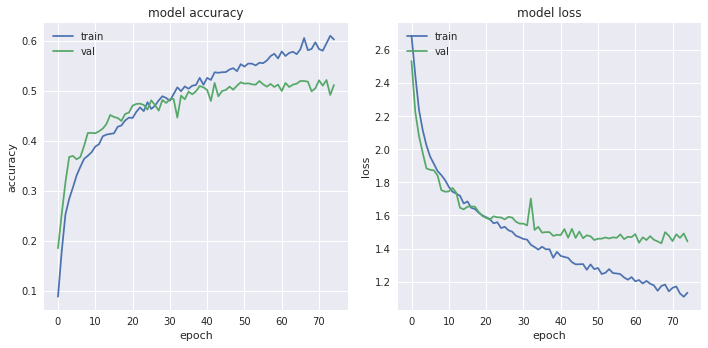

Time to train CNN is 266.8781430721283 seconds.


In [9]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
t1 = time()
if(True == augmentation):
    datagen = ImageDataGenerator(rotation_range=60)
                             #width_shift_range=0.5,
                             #height_shift_range=0.5,
                             #zoom_range = 0.5,
                             #horizontal_flip=True)
    datagen.fit(X_train_gray)
    history = model.fit_generator(datagen.flow(X_train_gray, y_train, batch_size = BATCH_SIZE),
                                  steps_per_epoch = X_train_gray.shape[0],                          
                                  epochs=EPOCHS,
                                  validation_data=(X_val_gray, y_val),
                                  callbacks=[checkpointer],
                                  verbose=0)
else:
    history = model.fit(X_train_gray, y_train, 
                        validation_data=(X_val_gray, y_val), 
                        epochs=EPOCHS, batch_size=BATCH_SIZE, 
                        callbacks=[checkpointer], 
                        verbose=0)
# list all data in history
#print(history.history.keys())

# summarize history for accuracy and loss
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')
f.tight_layout()
plt.show()
dt = time() - t1
print('Time to train CNN is', dt, 'seconds.' )

### 5. Accuracy of the classifier on test set

In [10]:
score = model.evaluate(X_test_gray, y_test, verbose=0)
print('Accuracy of the CNN classifier on test set is', score[1]*100, '%')

Accuracy of the CNN classifier on test set is 50.933333381 %


### 6. Confusion matrix

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


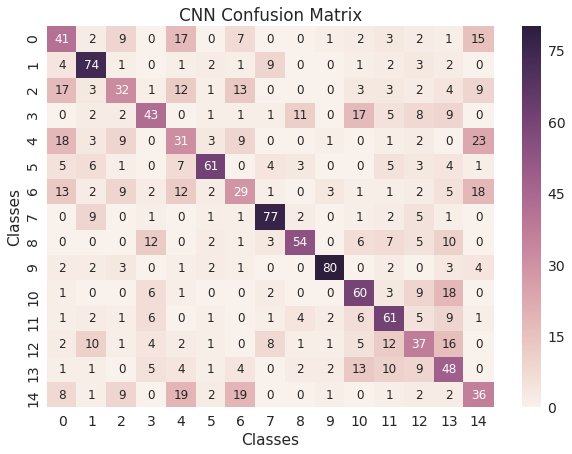

In [11]:
Y_pred = model.predict(X_test_gray)
y_pred = np.argmax(Y_pred, axis = 1)

cm = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
#print(cm)
df_cm = pd.DataFrame(cm, range(NUM_CLASSES), range(NUM_CLASSES))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})
plt.title('CNN Confusion Matrix')
plt.xlabel('Classes')
plt.ylabel('Classes')
plt.show()